In [1]:

import os 
import time

import pandas as pd
import numpy as np

from skbio.stats.composition import closure
from skbio.stats.composition import multiplicative_replacement
from skbio.stats.composition import clr

import scipy
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from combat.pycombat import pycombat

import matplotlib.pyplot as plt
import seaborn as sns
import pylab 

os.chdir("/home/ptruong/git/lifeAndDeath/scripts")
from get_columns import get_cell_line_state_replicate, get_base_cols_peptide, get_all_reporter_intensity_correct, get_reporter_intensity_without_control
from column_mapper import col_to_treatment_mapper, treatment_nomenclature_map_dict, col_to_cell_line_mapper, col_to_state_mapper, col_to_rep_mapper
from get_variables import get_cell_line_states_replicates_from_reporter_intensity_cols
from midx import col_to_mIdx, intensities_to_midx_df, diffacto_col_to_mIdx, diffacto_to_midx_df
from pd_functions import drop_zero_row
from transform import aitchison_transform_part, aitchison_transform, norm_SL, calcNormFactors, irs_norm
from plot import plot_kde, kde_matrix_plot_all_channels, plot_kde_batch, kde_matrix_plot_batch, plot_intensity_boxplot, plot_diffacto_pca, plot_diffacto_pca_cell_line, pca_plot_ax, get_significant_proteins, volcano_plot, kde_matrix_all_samples 
from top3 import top3, protSum_col_to_mIdx, protSum_intensities_to_midx_df, aggregate_protein_quantity, get_p_matrix
from de_analysis import get_log2FC_regulation, get_log2FC
from q_value import qvalues

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None
os.chdir("/home/ptruong/git/lifeAndDeath/data/amirata")
df_raw = pd.read_csv("peptides tryptic.csv", sep = "\t")


/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (696,704) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:

base_cols = get_base_cols_peptide()

reporter_intensity_corrected_cols = get_all_reporter_intensity_correct()
cell_lines, states, replicates = get_cell_line_states_replicates_from_reporter_intensity_cols(reporter_intensity_corrected_cols)

df_base = df_raw[get_base_cols_peptide()]


# filter df
df = df_raw[df_raw.PEP < 0.05] # 5% PEP removed 9578 peptides
df = df[df["Missed cleavages"] < 3] # 0 removed
df = df.set_index("Leading razor protein")

df.sort_values(by="Score", ascending=False, inplace=True)
df_int = df[reporter_intensity_corrected_cols + ["Score"]]
df_int.sort_values(by="Score", ascending=False, inplace=True)

protein_array = []
proteinQuant_array = []
for protein, peptides in df_int.groupby(df_int.index):
    proteinQuant = peptides.head(1).drop("Score", axis = 1)
    proteinQuant_array.append(proteinQuant.values[0])
    protein_array.append(protein)

df_int = pd.DataFrame(proteinQuant_array, index = protein_array, columns = df_int.drop("Score",axis=1).columns)

df_int = df_int.drop_duplicates() # Removing duplicate rows, these are most likely 0 rows. 2126 rows dropped
df_int = drop_zero_row(df_int) # dropped last zero-row


In [3]:
df_int = intensities_to_midx_df(df_int)

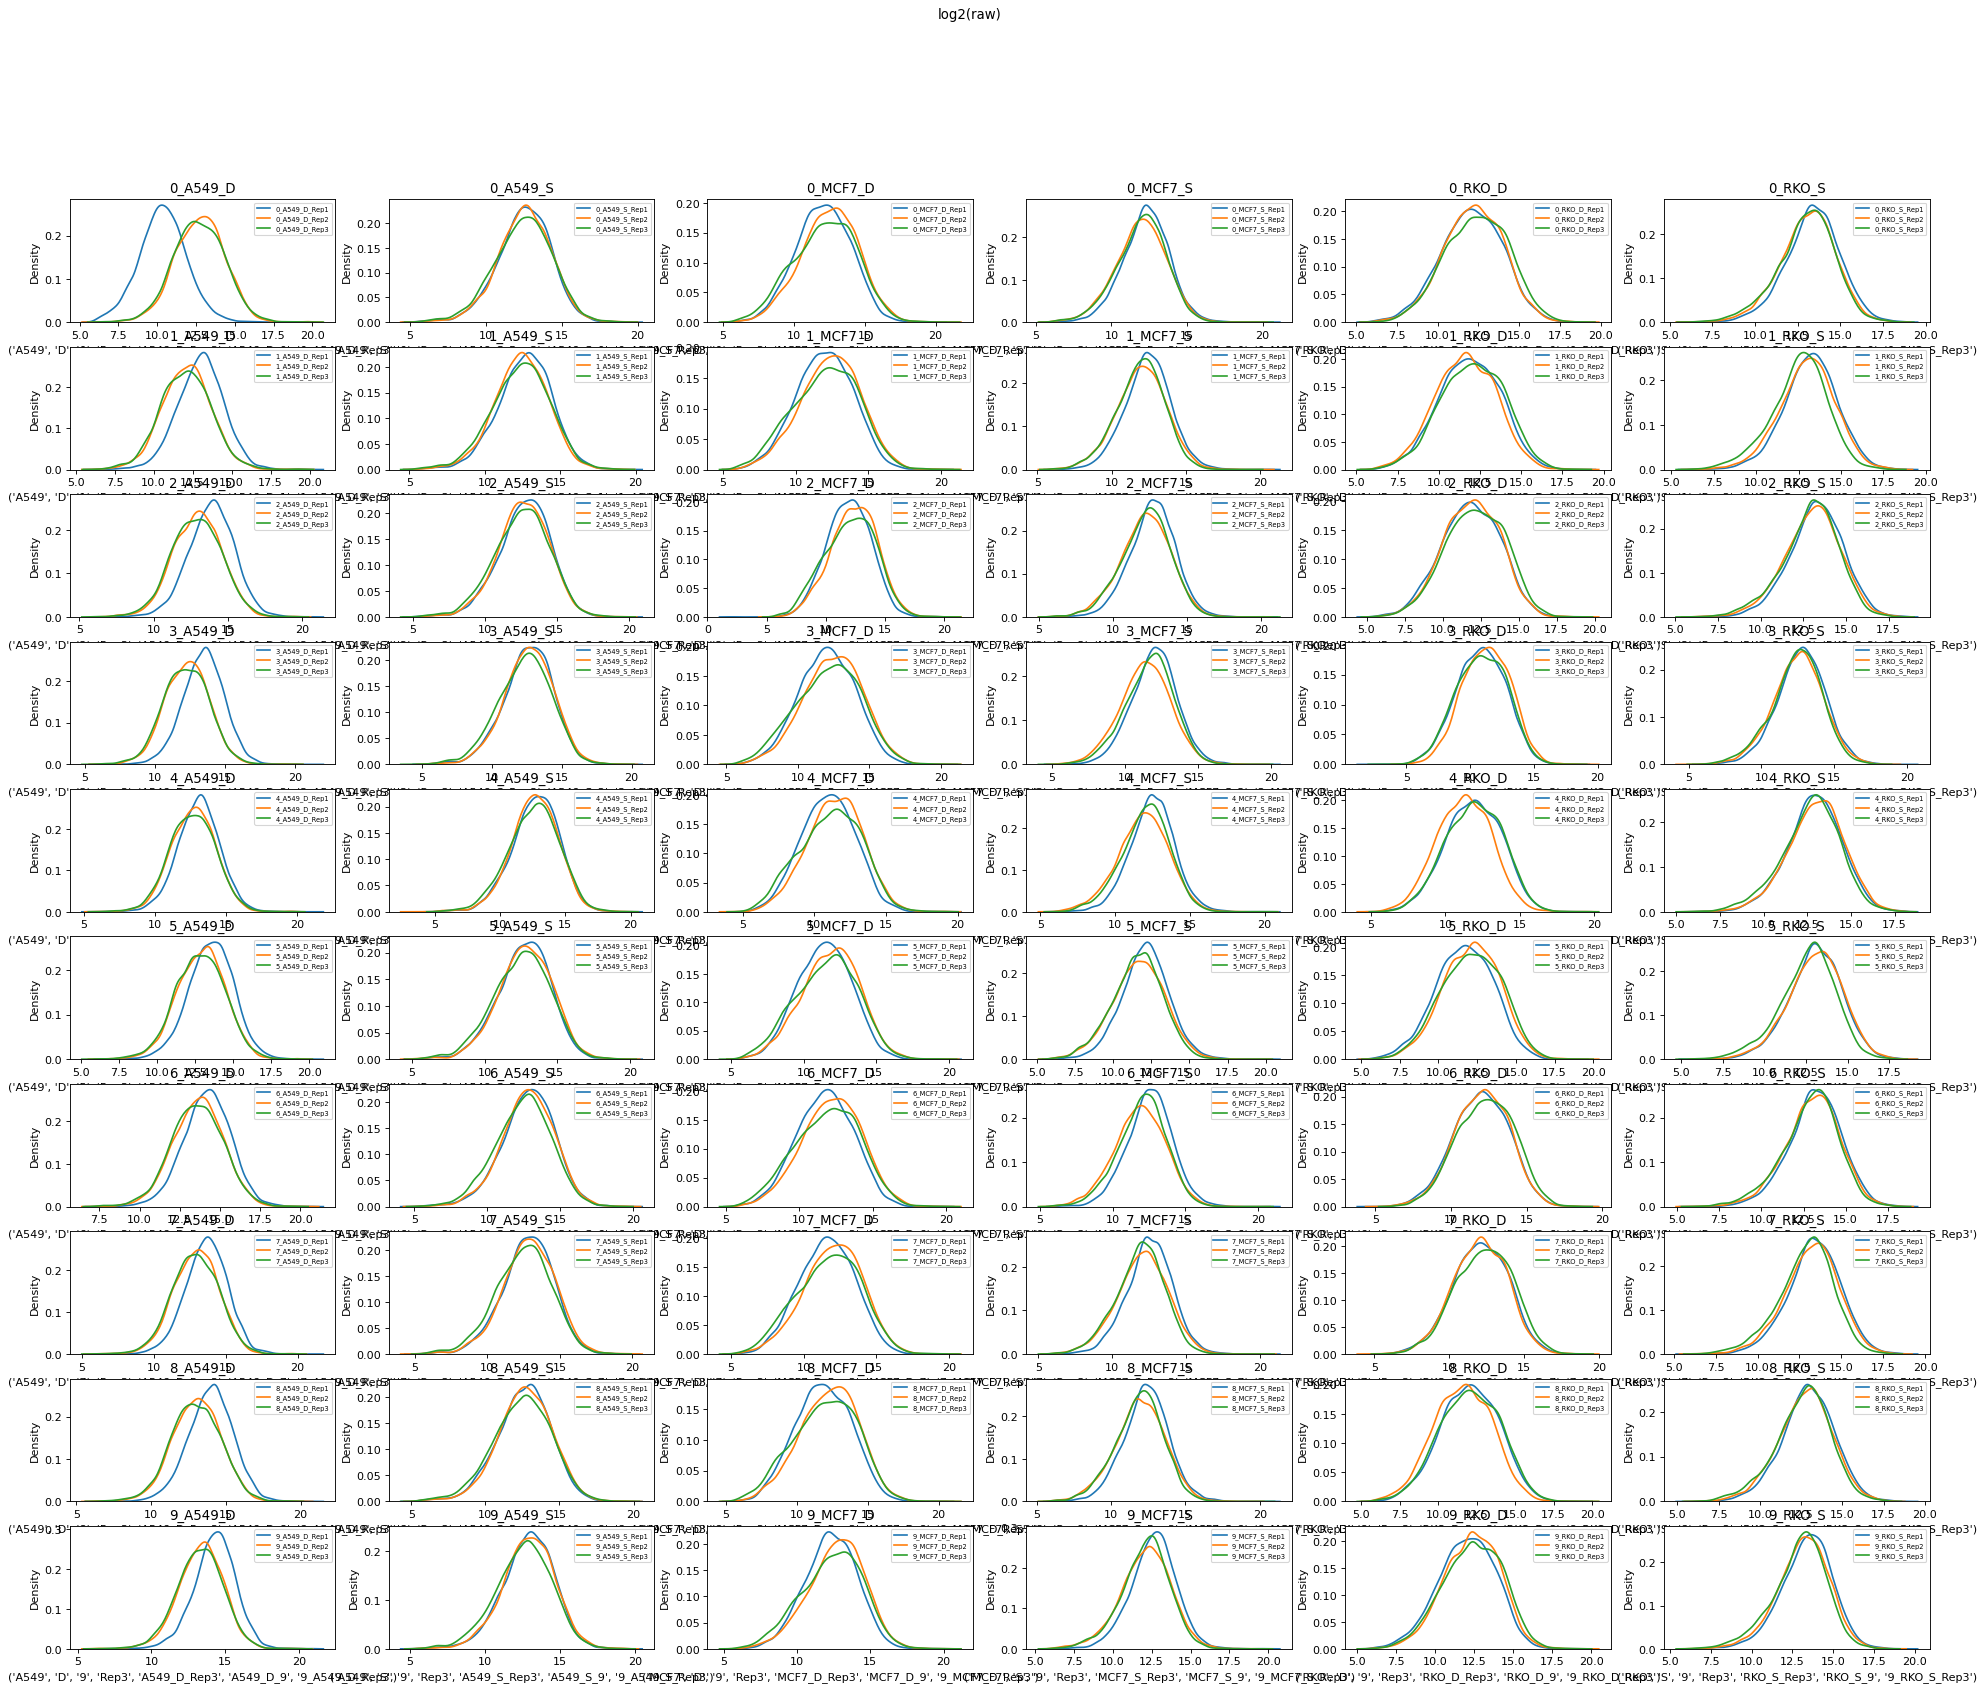

In [6]:
plt.figure(figsize=(30, 24), dpi=80)
kde_matrix_all_samples(df_int, log = True, suptitle ="log2(raw)")


In [7]:
# IRS-TMM NORM
df_norm = norm_SL(df_int)
df_irs = irs_norm(df_norm)
irs_tmm = calcNormFactors(df_irs.fillna(0))
df_irs_tmm = df_irs/(irs_tmm)


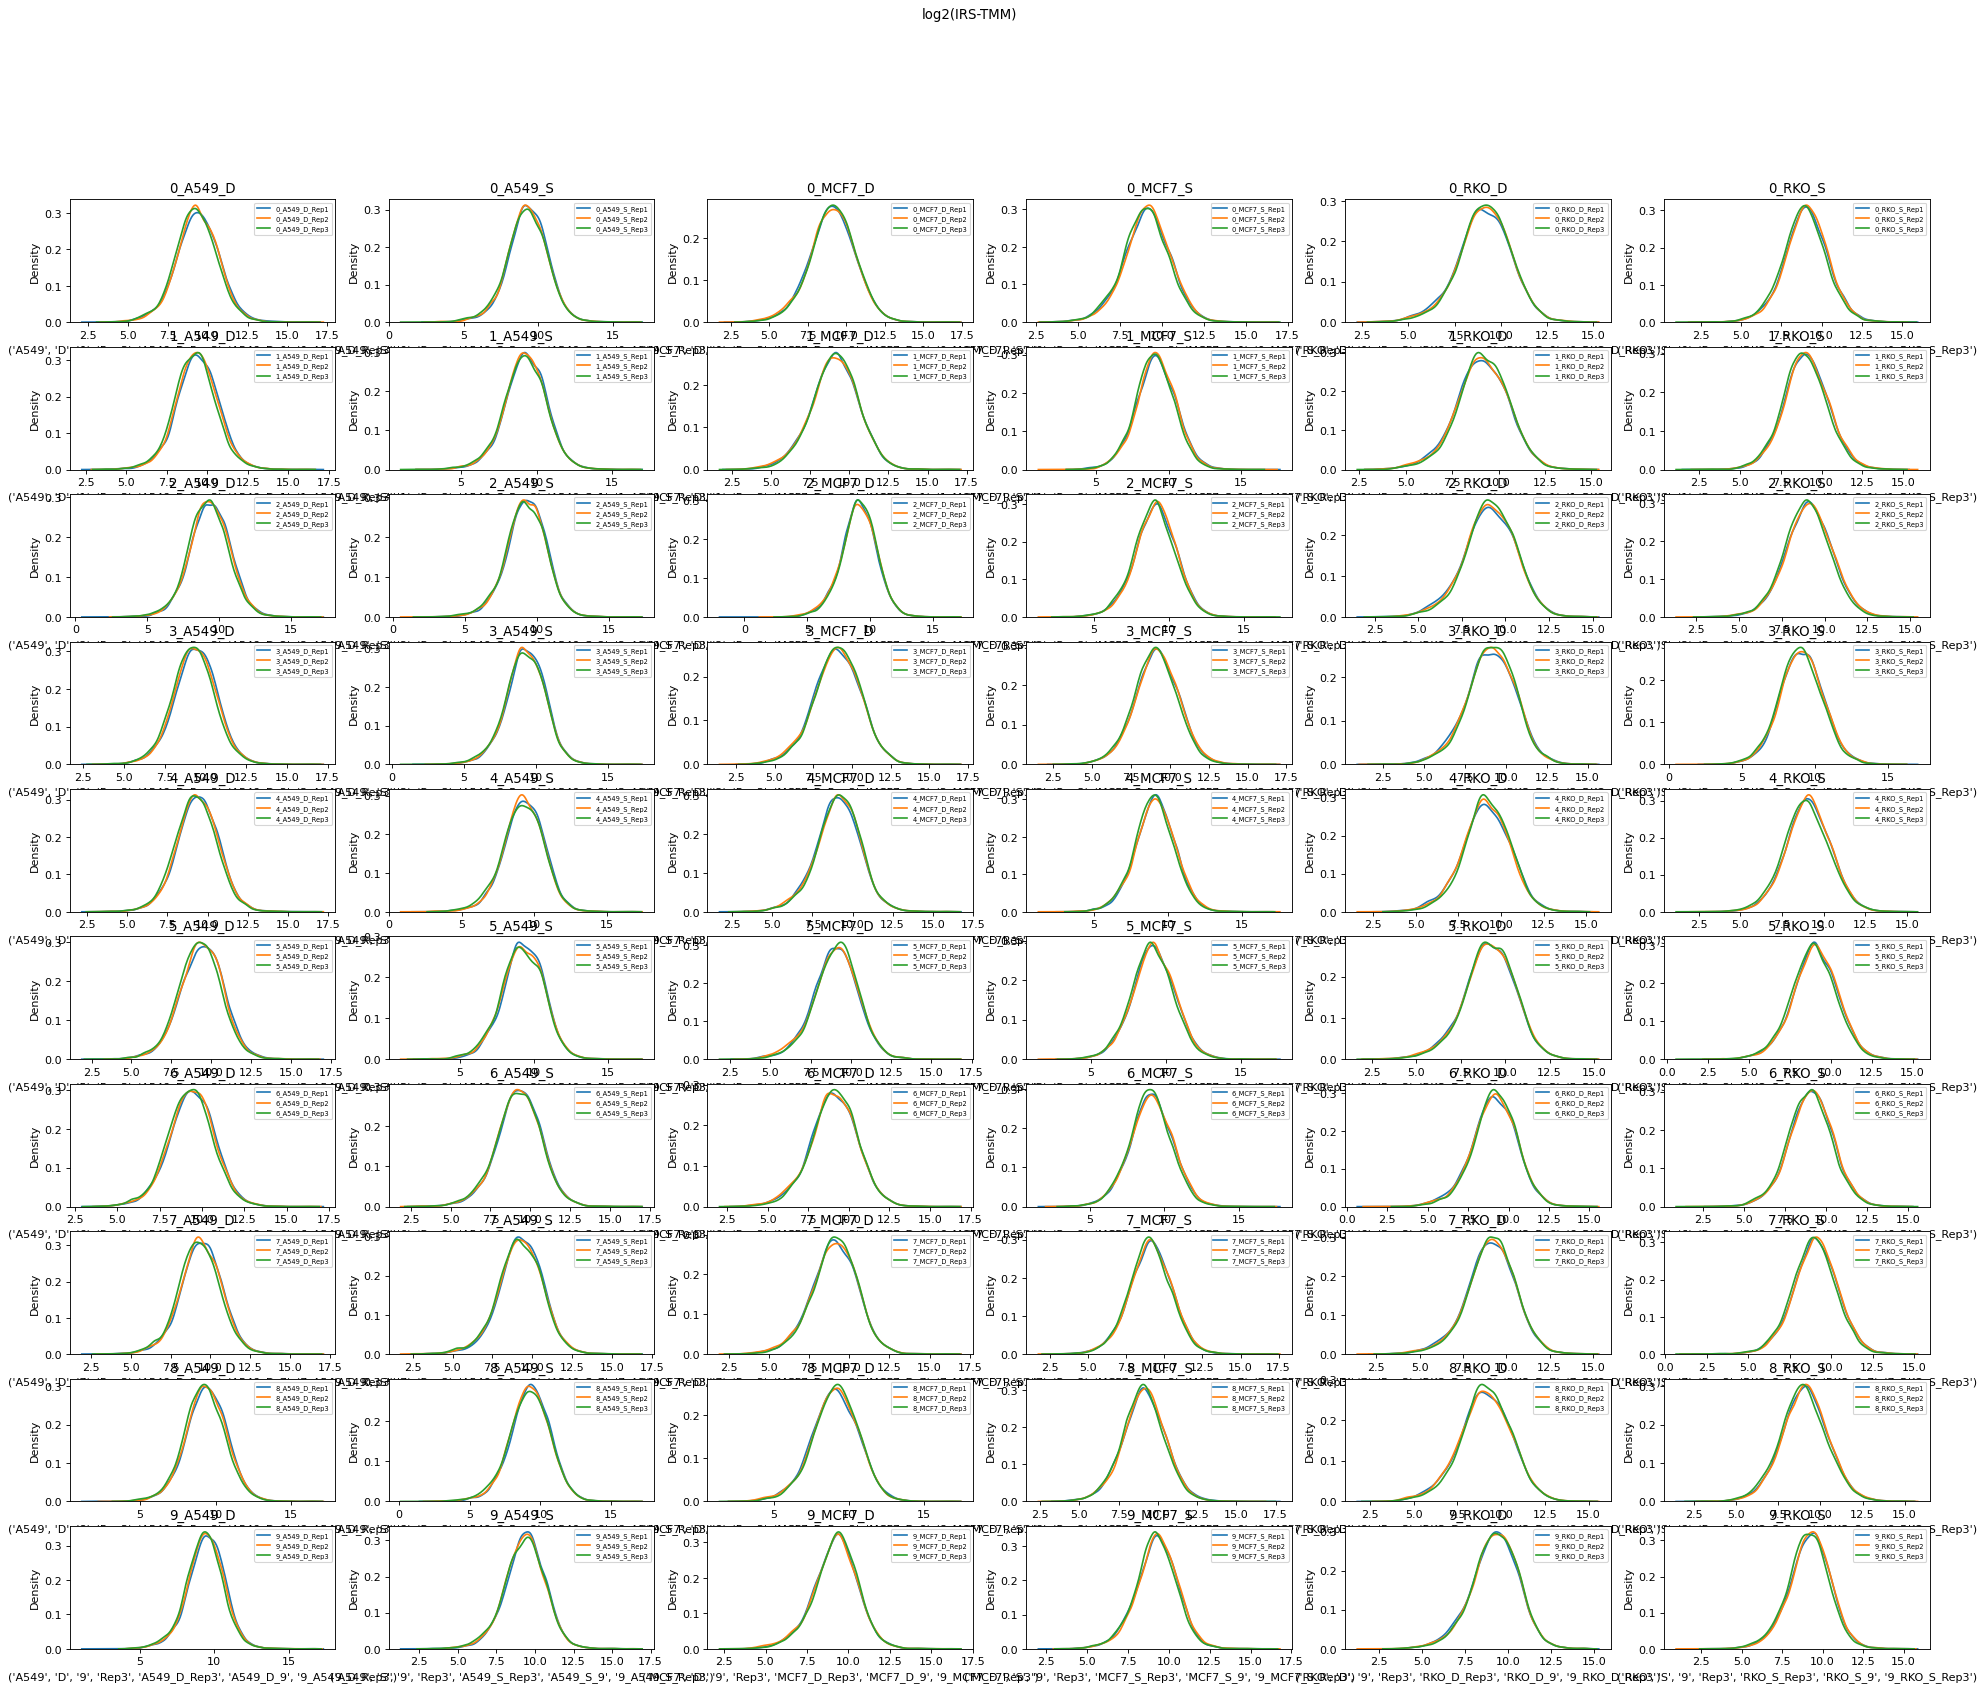

In [8]:
plt.figure(figsize=(30, 24), dpi=80)
kde_matrix_all_samples(df_irs_tmm, log = True, suptitle ="log2(IRS-TMM)")


In [9]:
def compute_log2FC(df_int):
    cell_lines = [ "A549", "MCF7", "RKO"]
    states = ["S", "D"]
    replicates = ["Rep1", "Rep2", "Rep3"]
    treatments = [i for i in range(10)]

    df_int = df_int.replace(0, np.nan)
    df_log2 = np.log2(df_int)

    fc_array = []
    for cell_line in cell_lines:
        for state in states:
            for rep in replicates:
                df_sample = df_log2.iloc[:,df_log2.columns.get_level_values("batch") == f"{cell_line}_{state}_{rep}"]
                case = df_sample.iloc[:, df_sample.columns.get_level_values("treatment") != "0"]
                control = df_sample.iloc[:, df_sample.columns.get_level_values("treatment") == "0"]
                fc = pd.DataFrame((control.values - case.values), index = case.index, columns = case.columns)
                fc_array.append(fc)


    df_fc = pd.concat(fc_array, axis = 1)
    return df_fc

In [49]:
df_log2FC = compute_log2FC(df_int)
df_log2FC_norm = compute_log2FC(df_irs_tmm)

In [11]:
def split_surviving_dead(df_fc, cell_lines = ["A549", "MCF7", "RKO"]):
    # df_fc = df_log2FC
    S = df_fc[cell_lines].iloc[:, (df_fc[cell_lines].columns.get_level_values("state") == "S")]
    D = df_fc[cell_lines].iloc[:, df_fc[cell_lines].columns.get_level_values("state") == "D"]
    S = pd.DataFrame(S.values, index = S.index, columns = S.columns.get_level_values("experiment"))
    D = pd.DataFrame(D.values, index = D.index, columns = D.columns.get_level_values("experiment"))
    col_mapper = lambda x: x.split("_")[0] + "_" + x.split("_")[1] + "_" + x.split("_")[-1] 
    S = S.rename(columns = col_mapper)
    D = D.rename(columns = col_mapper)
    SD = pd.concat([S.stack() ,D.stack()], axis = 1).rename(columns={0:"S", 1:"D"})
    return S, D, SD


In [50]:
S,D,SD = split_surviving_dead(df_log2FC)
Sn,Dn,SDn = split_surviving_dead(df_log2FC_norm)

Text(0.5, 1.0, 'FC S vs D (IRS-TMM normalized) ')

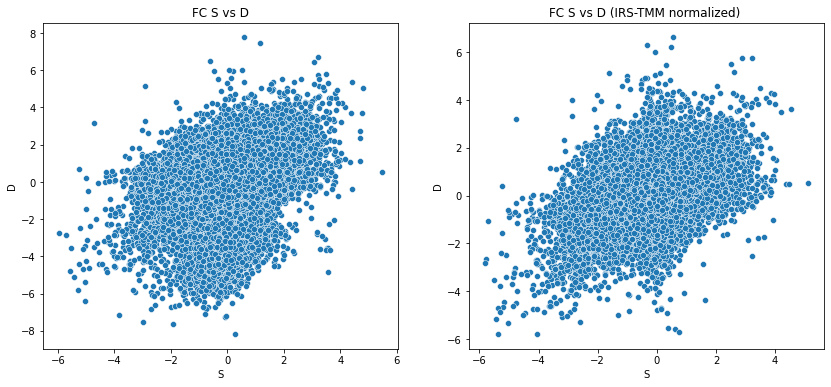

In [51]:
fig, axs = plt.subplots(1, 2, figsize = (14,6))

sns.scatterplot(data = SD, x = "S", y = "D", ax = axs[0])
axs[0].set_title("FC S vs D")
sns.scatterplot(data = SDn, x = "S", y = "D", ax = axs[1])
axs[1].set_title("FC S vs D (IRS-TMM normalized) ")

In [52]:
# same thing but for summed protein, perform t-test to filter away trash
def shapiro(df):
    shapiro = pd.DataFrame(df.apply(stats.shapiro, axis = 1).tolist(), index = df.index)
    shapiro["q"] = qvalues(shapiro, pcolname="pvalue") 
    return shapiro

shapiro_S = shapiro(S) #Shapiro p > 0.05 indicates normality
shapiro_D = shapiro(D)
S_idx = shapiro_S[shapiro_S.q > 0.05].index
D_idx = shapiro_D[shapiro_D.q > 0.05].index
idx = list(set(S_idx) & set(D_idx))

shapiro_Sn = shapiro(Sn) 
Sn_idx = shapiro_Sn[shapiro_Sn.q > 0.05].index
Dn_idx = shapiro_Dn[shapiro_Dn.q > 0.05].index
idx = list(set(Sn_idx) & set(Dn_idx))

Text(0.5, 1.0, 'Dn')

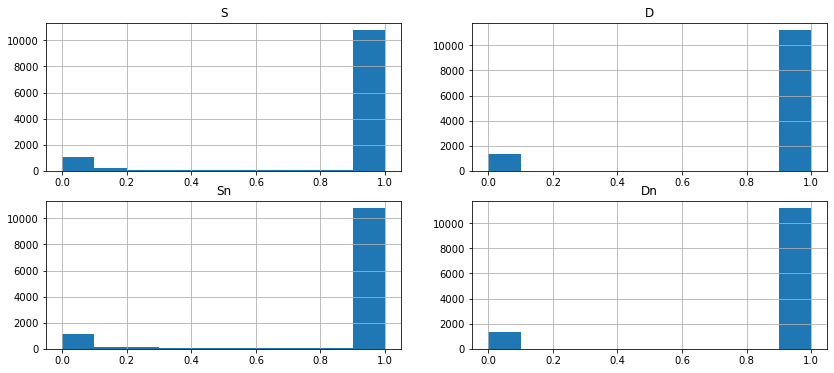

In [53]:
fig, axs = plt.subplots(2, 2, figsize = (14,6))
shapiro_S.pvalue.hist(ax = axs[0,0])
axs[0,0].set_title("S")
shapiro_D.pvalue.hist(ax = axs[0,1])
axs[0,1].set_title("D")

shapiro_Sn.pvalue.hist(ax = axs[1, 0])
axs[1,0].set_title("Sn")
shapiro_Dn.pvalue.hist(ax = axs[1,1 ])
axs[1,1].set_title("Dn")


Text(0.5, 1.0, 'Dn')

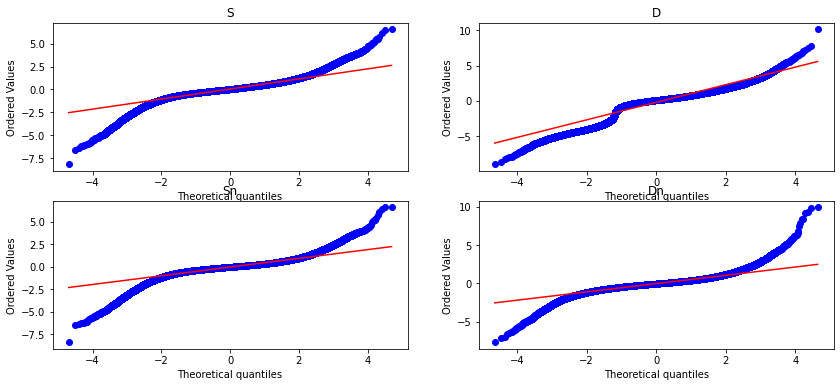

In [54]:
fig, axs = plt.subplots(2, 2, figsize = (14,6))
stats.probplot(S.stack().values, dist = "norm", plot=axs[0,0])
axs[0,0].set_title("S")
stats.probplot(D.stack().values, dist = "norm", plot=axs[0,1])
axs[0,1].set_title("D")
stats.probplot(Sn.stack().values, dist = "norm", plot=axs[1,0])
axs[1,0].set_title("Sn")
stats.probplot(Dn.stack().values, dist = "norm", plot=axs[1,1])
axs[1,1].set_title("Dn")


Text(0.5, 1.0, 'BoxCox(Dn)')

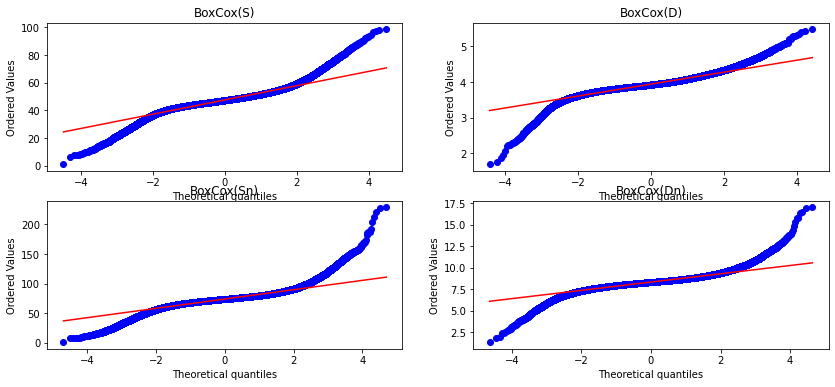

In [116]:
# Attempt Box-Cox transformation to make the data fit normal distribution
shift = 10
fig, axs = plt.subplots(2, 2, figsize = (14,6))

stats.probplot(stats.boxcox(S.stack().values + shift)[0], dist = "norm", plot=axs[0,0])
axs[0,0].set_title("BoxCox(S)")
stats.probplot(stats.boxcox(D.stack().values + shift)[0], dist = "norm", plot=axs[0,1])
axs[0,1].set_title("BoxCox(D)")

stats.probplot(stats.boxcox(Sn.stack().values + shift)[0], dist = "norm", plot=axs[1,0])
axs[1,0].set_title("BoxCox(Sn)")
stats.probplot(stats.boxcox(Dn.stack().values + shift)[0], dist = "norm", plot=axs[1,1])
axs[1,1].set_title("BoxCox(Dn)")

Text(0.5, 1.0, 'All samples S and D (IRS-TMM normalized) Probability Plot')

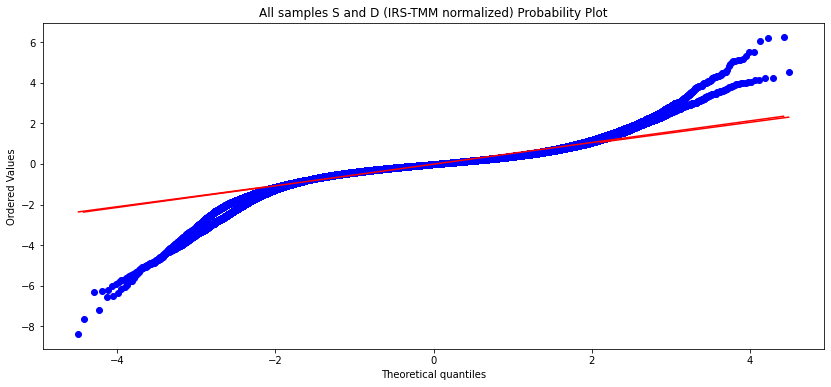

In [60]:
plt.figure(figsize=(14,6))
stats.probplot(Sn.stack().values, dist = "norm", plot=pylab)
stats.probplot(Dn.stack().values, dist = "norm", plot=pylab)
plt.title("All samples S and D (IRS-TMM normalized) Probability Plot")

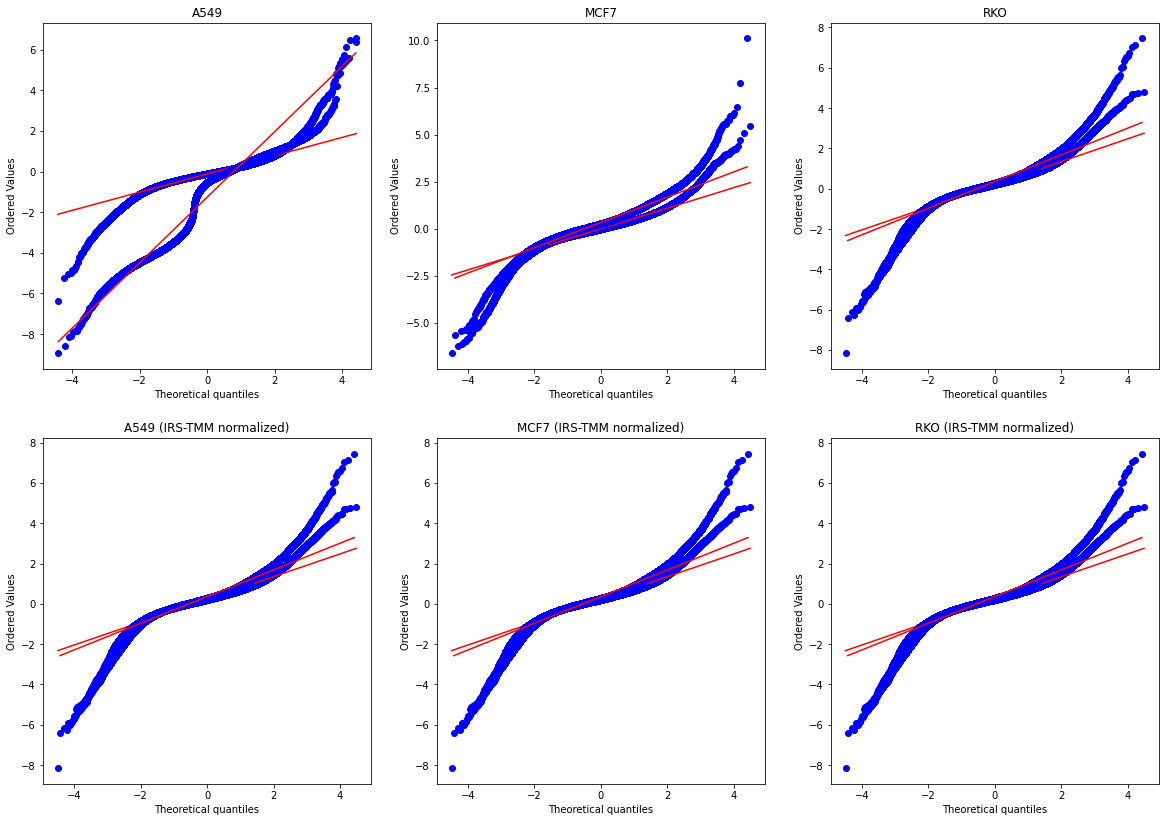

In [59]:
fig, axs = plt.subplots(2, 3, figsize = (20,14))
i=0
for cell_line in cell_lines:
    S,D,SD = split_surviving_dead(df_log2FC, cell_lines = [cell_line])
    stats.probplot(S.stack().values, dist = "norm", plot=axs[0,i])
    stats.probplot(D.stack().values, dist = "norm", plot=axs[0,i])
    axs[0,i].set_title(f"{cell_line}")
    i+=1

i=0
for cell_line in cell_lines:
    Sn,Dn,SDn = split_surviving_dead(df_log2FC_norm, cell_lines = [cell_line])
    stats.probplot(S.stack().values, dist = "norm", plot=axs[1,i])
    stats.probplot(D.stack().values, dist = "norm", plot=axs[1,i])
    axs[1,i].set_title(f"{cell_line} (IRS-TMM normalized)")
    i+=1
    


Text(0.5, 1.0, 'Histogram Sn and Dn')

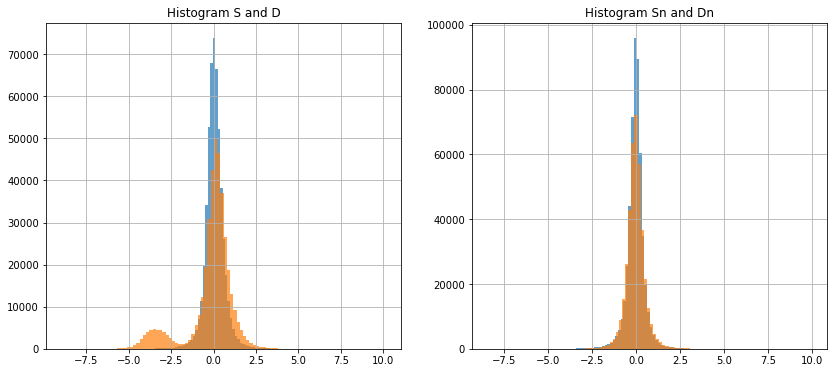

In [57]:
fig, axs = plt.subplots(1, 2, figsize = (14,6))
S.stack().hist(bins = 100, alpha=0.7,ax=axs[0])
D.stack().hist(bins = 100, alpha=0.7,ax=axs[0])
axs[0].set_title("Histogram S and D")
Sn.stack().hist(bins = 100, alpha=0.7,ax=axs[1])
Dn.stack().hist(bins = 100, alpha=0.7,ax=axs[1])
axs[1].set_title("Histogram Sn and Dn")

Normlized log2Fc data seeem to behave well... But the tails seems to be fat.

According to [Wilcox R. 2003]( https://reader.elsevier.com/reader/sd/pii/B9780127515410500304?token=701DAE6FF09961791D16C37E230FF925A01C2B51466FA2D93C8D815F65489621ECBA155D15C1C2E6301B8C0A8A45DC03&originRegion=eu-west-1&originCreation=20210429134758) testing the hypothesis of equal means using ANOVA is more appropriate for normal och thin-tailed ANOVA, whereas testing the hypothesis of equal medians is more appropriate for heavy-tailed distributions (also known as Kruskal-Wallis ANOVA). 

Cited from the text:

"The median has a relatively large standard error under normality and more generallywhen sampling from a light-tailed distribution, but with a sufficiently heavy-taileddistribution its standard error can be relatively small"

I guess the long tails can affect the mean quite alot, but median should be quite stable. But using Kruskal-Wallis we lose some power.


We have the rules:
Mean anova - with Tukey HSD post hoc test
Kruskal Wallis -  with dunn's post hoc test

5 assumptions for Kruskal Wallis one-way ANOVA (Non-parametric ANOVA)
1. Independent variables are categorical variables ( more than 2 levels)
2. Dependent variables is continue variable.
3. Independence assumption = ok
4. Normality assumption = violation
5. Equality of variance assumption= violation

Other recommendations:
-  General Linear Model instead of ANOVA (need to check this).
- Check transformations for long-tailed data.

Long tail transformations:
- triummed tailes
- power transformations.
-  Box-Cox transform


Links
https://www.researchgate.net/post/One-Way-ANOVA-or-Kruskal-Wallis-which-one-should-I-use

"ANOVA is not sensitive to fat failed"
https://news.ycombinator.com/item?id=5978540

"Early research shows ANOVA is robust, but it is fairly easy to show that extreme values can impact ANOVA even in large sample sizes"
https://www.researchgate.net/post/Is_ANOVA_robust_and_to_what_extent

We seem to have info telling us both ways and mean ANOVA should give us more power. We can perform both can compare results.

In [61]:
def kruskal_test(S,D):
    protein_array = []
    kruskal = []
    for protein in list(set(S.index) & set(D.index)):        
        S_val = S[S.index == protein].values[0]
        if np.isnan(S_val).all():
            continue
        D_val = D[D.index == protein].values[0]
        if np.isnan(D_val).all():
            continue
        kruskal_p = stats.kruskal(S_val,D_val,nan_policy = "omit")[1]
        kruskal.append(kruskal_p)
        protein_array.append(protein)
    
    kruskal = pd.DataFrame(kruskal, index = protein_array, columns = ["p"])
    kruskal.sort_values(by = "p", inplace=True)
    kruskal["q"] = qvalues(kruskal, pcolname = "p")
    return kruskal


In [63]:
Sn,Dn,SDn = split_surviving_dead(df_log2FC_norm, cell_lines = ["A549", "MCF7", "RKO"])


In [68]:
kruskal = kruskal_test(Sn,Dn)

Text(0.5, 1.0, 'Kruskal-Wallis q-values')

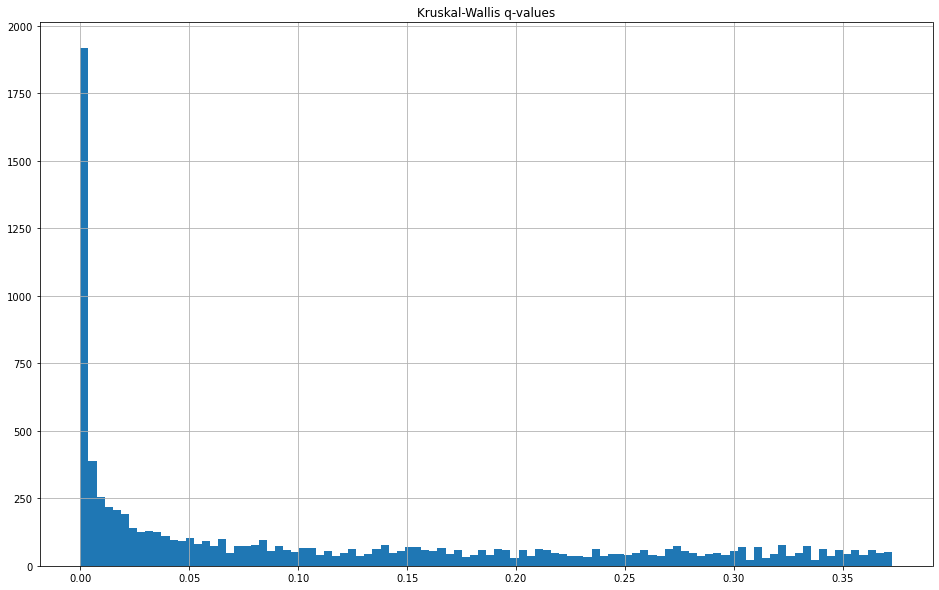

In [74]:
plt.figure(figsize=(16,10))
kruskal.q.hist(bins = 100)
plt.title("Kruskal-Wallis q-values")

In [119]:
print("All proteins :" +str(len(kruskal)))
print("Kruskal q < 0.01 :" + str(len(kruskal[kruskal.q<0.01])))

All proteins :8722
Kruskal q < 0.01 :2481


In [120]:
kruskal_A549 = kruskal_test(Sn.filter(regex = "A549"),Dn.filter(regex = "A549"))
print("All A549 proteins :" +str(len(kruskal_A549)))
print("Kruskal q < 0.01 :" + str(len(kruskal_A549[kruskal_A549.q<0.01])))

All A549 proteins :4855
Kruskal q < 0.01 :1760


In [121]:
kruskal_RKO = kruskal_test(Sn.filter(regex = "RKO"),Dn.filter(regex = "RKO"))
print("All RKO proteins :" +str(len(kruskal_RKO)))
print("Kruskal q < 0.01 :" + str(len(kruskal_RKO[kruskal_RKO.q<0.01])))

All RKO proteins :5672
Kruskal q < 0.01 :794


In [122]:
kruskal_MCF7 = kruskal_test(Sn.filter(regex = "MCF7"),Dn.filter(regex = "MCF7"))
print("All RKO proteins :" +str(len(kruskal_MCF7)))
print("Kruskal q < 0.01 :" + str(len(kruskal_MCF7[kruskal_MCF7.q>0.01])))

All RKO proteins :4897
Kruskal q < 0.01 :3125


In [123]:
treatments = [i for i in range(1,10)]
case_array = []
kruskal_case_array = []

start=time.time()
for cell_line in cell_lines:
    for treatment in treatments:
        kruskal_case = kruskal_test(Sn.filter(regex = f"{treatment}_{cell_line}"), 
                                     Dn.filter(regex = f"{treatment}_{cell_line}"))
        kruskal_case_array.append(kruskal_case)
        case_array.append(f"{treatment}_{cell_line}")
        print(f"All {treatment}_{cell_line} proteins :" +str(len(kruskal_case)))
        print(f"Kruskal q < 0.01 :" + str(len(kruskal_case[kruskal_case.q<0.01])))
        print("---")
        print(" ")
end=time.time()
print(end-start)

All 1_A549 proteins :4850
Kruskal q < 0.01 :0
---
 
All 2_A549 proteins :4852
Kruskal q < 0.01 :0
---
 
All 3_A549 proteins :4852
Kruskal q < 0.01 :0
---
 
All 4_A549 proteins :4853
Kruskal q < 0.01 :0
---
 
All 5_A549 proteins :4853
Kruskal q < 0.01 :0
---
 
All 6_A549 proteins :4852
Kruskal q < 0.01 :0
---
 
All 7_A549 proteins :4854
Kruskal q < 0.01 :0
---
 
All 8_A549 proteins :4855
Kruskal q < 0.01 :0
---
 
All 9_A549 proteins :4853
Kruskal q < 0.01 :0
---
 
All 1_MCF7 proteins :4883
Kruskal q < 0.01 :0
---
 
All 2_MCF7 proteins :4884
Kruskal q < 0.01 :0
---
 
All 3_MCF7 proteins :4886
Kruskal q < 0.01 :0
---
 
All 4_MCF7 proteins :4863
Kruskal q < 0.01 :0
---
 
All 5_MCF7 proteins :4876
Kruskal q < 0.01 :0
---
 
All 6_MCF7 proteins :4883
Kruskal q < 0.01 :0
---
 
All 7_MCF7 proteins :4885
Kruskal q < 0.01 :0
---
 
All 8_MCF7 proteins :4884
Kruskal q < 0.01 :0
---
 
All 9_MCF7 proteins :4891
Kruskal q < 0.01 :0
---
 
All 1_RKO proteins :5663
Kruskal q < 0.01 :0
---
 
All 2_RKO pro

Seems like the sample size for performing Kruskal-Wallis ANOVA for each group is too small. 

In [117]:
stats.f_oneway(Sn, Dn, axis = 1)

F_onewayResult(statistic=array([       nan,        nan,        nan, ..., 7.49616695,        nan,
              nan]), pvalue=array([      nan,       nan,       nan, ..., 0.0068836,       nan,
             nan]))

In [124]:
kruskal_A549

,p,q
CON__ENSEMBL:ENSBTAP00000034412,2.866323e-10,0.0
CON__P02769,2.866323e-10,0.0
CON__P01966,2.866323e-10,0.0
B0YIW2,2.866323e-10,0.0
CON__P12763,3.581806e-10,0.0
...,...,...
Q7Z7N9,1.000000e+00,0.330618
Q9BRU9,1.000000e+00,0.330618
Q9Y5A9,1.000000e+00,0.330618
Q6T4R5-2,1.000000e+00,0.330618
